ZIP carregado com sucesso.
CSV encontrado dentro do ZIP: Preços semestrais - AUTOMOTIVOS_2025.01.csv
Colunas normalizadas: Index(['i»¿regiao_-_sigla', 'estado_-_sigla', 'municipio', 'revenda',
       'cnpj_da_revenda', 'nome_da_rua', 'numero_rua', 'complemento', 'bairro',
       'cep', 'produto', 'data_da_coleta', 'valor_de_venda', 'valor_de_compra',
       'unidade_de_medida', 'bandeira'],
      dtype='object')
Corrigindo coluna: i»¿regiao_-_sigla → regiao_sigla
Corrigindo coluna: estado_-_sigla → estado_sigla
Colunas finais no Spark: ['regiao_sigla', 'estado_sigla', 'municipio', 'revenda', 'cnpj_da_revenda', 'nome_da_rua', 'numero_rua', 'complemento', 'bairro', 'cep', 'produto', 'data_da_coleta', 'valor_de_venda', 'valor_de_compra', 'unidade_de_medida', 'bandeira']


/home/spark-ed521ba5-7a8d-4058-a241-6f/.ipykernel/4280/command-6682678126776740-969497697:182: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_postos, x="lucro_total", y="revenda", palette="viridis")


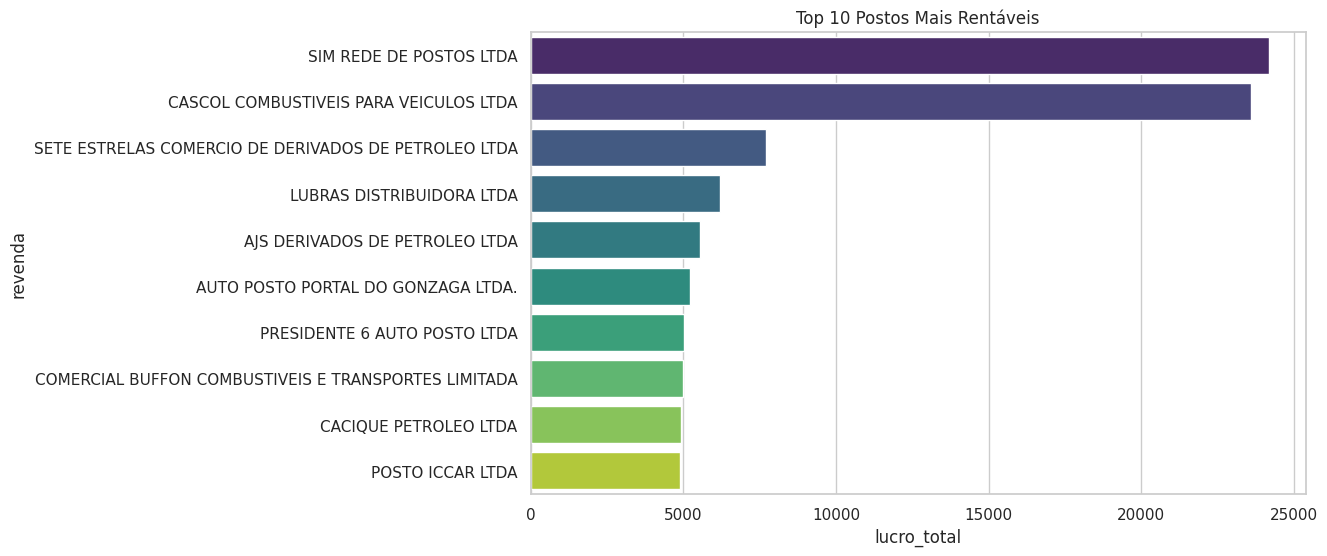

Estado mais lucrativo: SP


/home/spark-ed521ba5-7a8d-4058-a241-6f/.ipykernel/4280/command-6682678126776740-969497697:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bairros_lucrativos, x="lucro_total", y="bairro", palette="viridis")


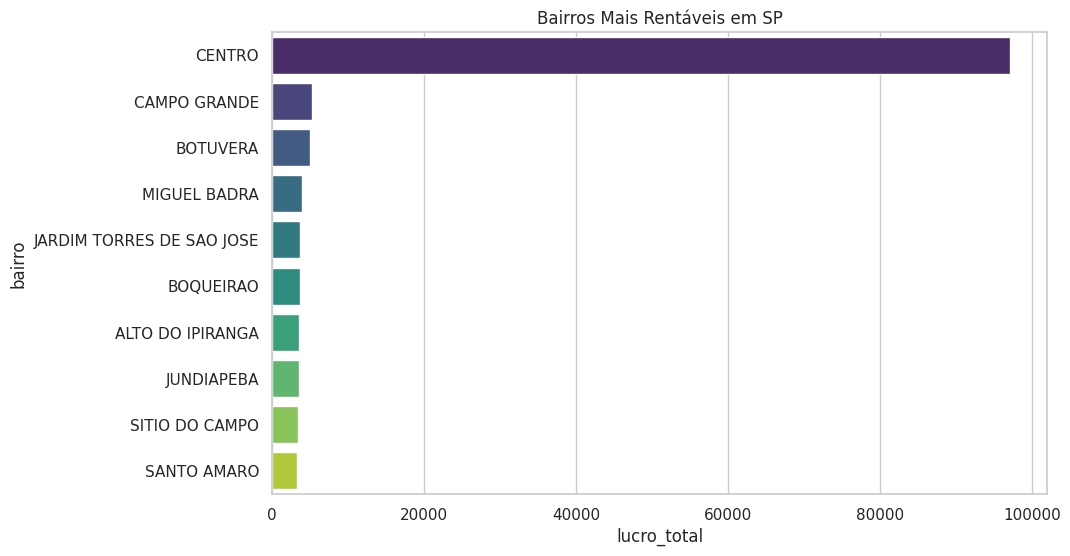

/home/spark-ed521ba5-7a8d-4058-a241-6f/.ipykernel/4280/command-6682678126776740-969497697:244: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bandeiras, x="lucro_total", y="bandeira", palette="coolwarm")
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 130 (\x82) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


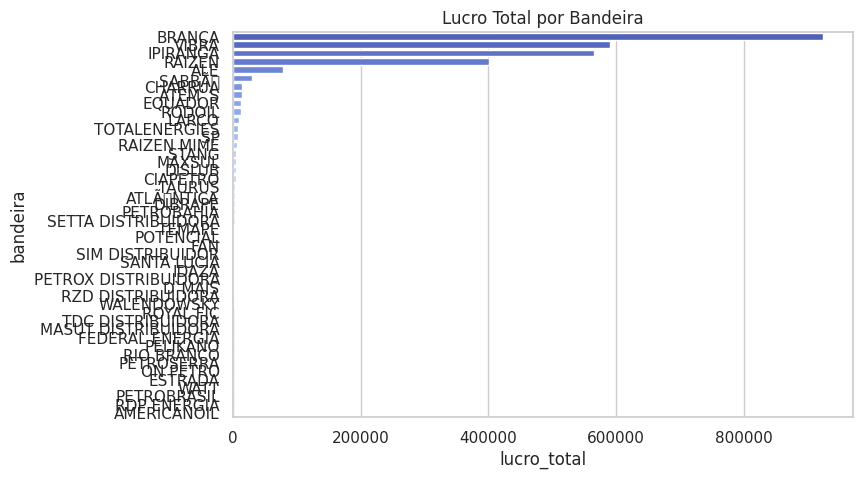

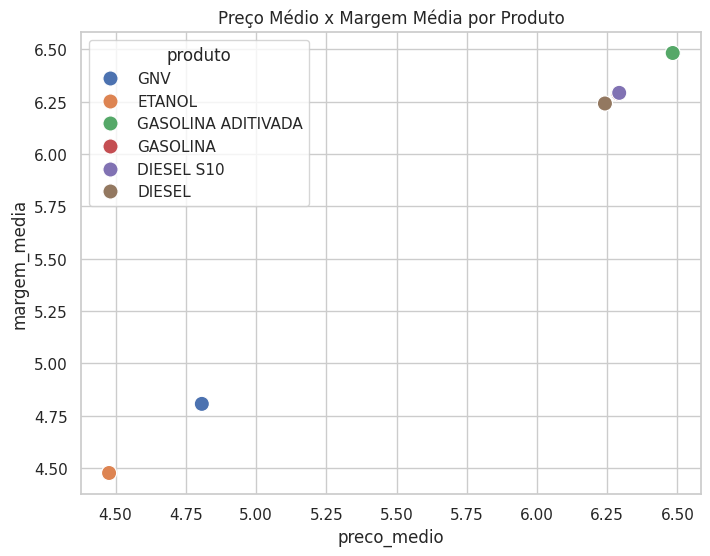

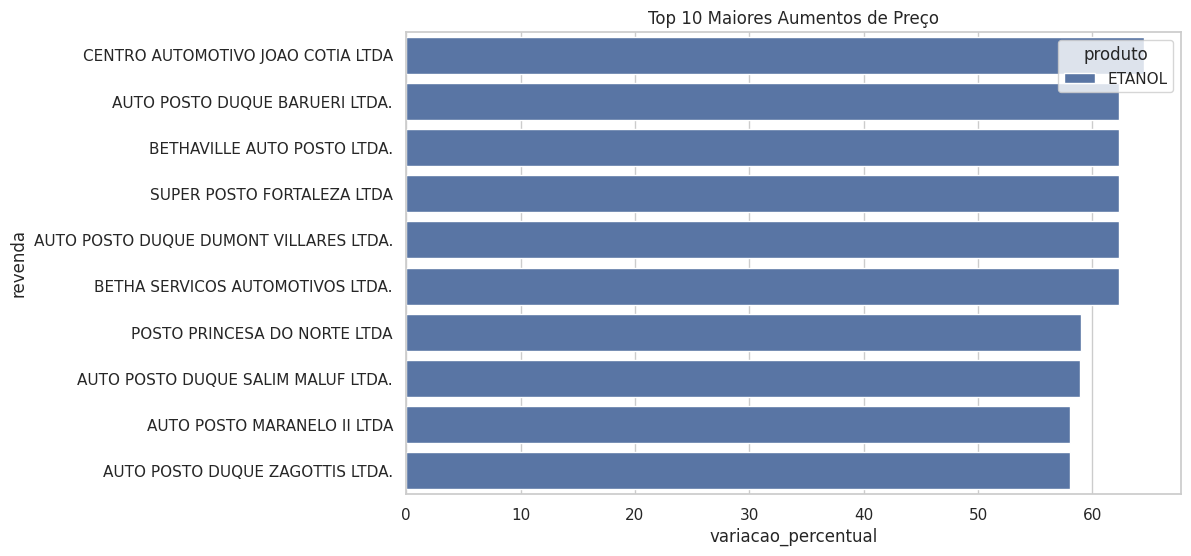

Nenhum produto/posto com margem negativa encontrado.


In [0]:
# ===========================================================
# IMPORTAÇÕES COMENTADAS
# ===========================================================
import requests                  # Para baixar arquivos da web (ZIP da ANP)
import zipfile                   # Para abrir e ler arquivos ZIP
import pandas as pd              # Manipulação de DataFrames
import unicodedata               # Remover acentos e normalizar texto
import io                        # Manipular bytes em memória (BytesIO)
from pyspark.sql import functions as F      # Funções SQL do Spark
from pyspark.sql.types import DoubleType    # Tipo double para colunas numéricas
import matplotlib.pyplot as plt  # Gráficos
import seaborn as sns            # Gráficos estilizados
sns.set(style="whitegrid")       # Estilo base


# ===========================================================
# BAIXAR E CARREGAR OS DADOS DA ANP (ZIP → CSV)
# ===========================================================
url_zip = "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2025-01.zip"

response = requests.get(url_zip)
response.raise_for_status()

zip_bytes = io.BytesIO(response.content)
print("ZIP carregado com sucesso.")

with zipfile.ZipFile(zip_bytes) as zip_ref:
    csv_name = [n for n in zip_ref.namelist() if n.lower().endswith(".csv")][0]
    csv_bytes = zip_ref.read(csv_name)

print(f"CSV encontrado dentro do ZIP: {csv_name}")


# ===========================================================
# LER CSV E NORMALIZAR COLUNAS
# ===========================================================
df = pd.read_csv(io.BytesIO(csv_bytes), sep=";", encoding="latin1", low_memory=False)

def normalize_column(col):
    col = col.lower()
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.replace(" ", "_")
    return col

df.columns = [normalize_column(c) for c in df.columns]

# Remover BOM
df.columns = [c.replace("ï»¿", "") for c in df.columns]

print("Colunas normalizadas:", df.columns)


# ===========================================================
# CONVERTER VALORES NUMÉRICOS (VENDA E COMPRA)
# ===========================================================
for coluna in ["valor_de_venda", "valor_de_compra"]:
    df[coluna] = (
        df[coluna]
        .astype(str)
        .str.replace(",", ".", regex=False)
    )
    df[coluna] = pd.to_numeric(df[coluna], errors="coerce")


# ===========================================================
# CRIAR DATAFRAME SPARK
# ===========================================================
spark_df = spark.createDataFrame(df)

# Converter novamente no Spark como segurança
spark_df = spark_df.withColumn("valor_de_venda",
    F.regexp_replace("valor_de_venda", ",", ".").cast(DoubleType())
)
spark_df = spark_df.withColumn("valor_de_compra",
    F.regexp_replace("valor_de_compra", ",", ".").cast(DoubleType())
)
spark_df = spark_df.withColumn("data_da_coleta",
    F.to_date("data_da_coleta", "dd/MM/yyyy")
)


# ===========================================================
# 3.1 — CORRIGIR NOMES DE COLUNA COM BOM NO SPARK
# ===========================================================
for col in spark_df.columns:
    # corrigir qualquer nome contendo 'regiao'
    if "regiao" in col:
        print(f"Corrigindo coluna: {col} → regiao_sigla")
        spark_df = spark_df.withColumnRenamed(col, "regiao_sigla")

    # corrigir qualquer nome contendo 'estado'
    if "estado" in col:
        print(f"Corrigindo coluna: {col} → estado_sigla")
        spark_df = spark_df.withColumnRenamed(col, "estado_sigla")


print("Colunas finais no Spark:", spark_df.columns)


# ===========================================================
# DIMENSÃO TEMPO
# ===========================================================
dim_tempo = (
    spark_df
    .select("data_da_coleta").distinct()
    .withColumn("ano", F.year("data_da_coleta"))
    .withColumn("mes", F.month("data_da_coleta"))
    .withColumn("dia", F.dayofmonth("data_da_coleta"))
    .withColumnRenamed("data_da_coleta", "data")
    .withColumn("tempo_id", F.monotonically_increasing_id())
)

dim_tempo.createOrReplaceTempView("dim_tempo")


# ===========================================================
# DIMENSÃO PRODUTO
# ===========================================================
dim_produto = (
    spark_df
    .select("produto", "unidade_de_medida").distinct()
    .withColumn("produto_id", F.monotonically_increasing_id())
)

dim_produto.createOrReplaceTempView("dim_produto")


# ===========================================================
# DIMENSÃO POSTO
# ===========================================================
dim_posto = (
    spark_df.select(
        "cnpj_da_revenda", "revenda", "nome_da_rua", "numero_rua",
        "complemento", "bairro", "cep", "municipio",
        "estado_sigla", "regiao_sigla", "bandeira"
    )
    .distinct()
    .withColumnRenamed("cnpj_da_revenda", "posto_id")
)

dim_posto.createOrReplaceTempView("dim_posto")


# ===========================================================
# FATO PREÇOS
# ===========================================================
fato_precos = (
    spark_df.alias("df")
    .join(dim_posto.alias("po"), F.col("df.cnpj_da_revenda") == F.col("po.posto_id"), "left")
    .join(dim_produto.alias("pr"), F.col("df.produto") == F.col("pr.produto"), "left")
    .join(dim_tempo.alias("t"), F.col("df.data_da_coleta") == F.col("t.data"), "left")
    .select(
        F.col("po.posto_id"),
        F.col("pr.produto_id"),
        F.col("t.tempo_id"),
        F.col("df.valor_de_venda"),
        F.col("df.valor_de_compra")
    )
)

fato_precos.createOrReplaceTempView("fato_precos")


# ===========================================================
# QUERY 1 — POSTOS MAIS RENTÁVEIS
# ===========================================================
query1 = spark.sql("""
    SELECT 
        po.revenda,
        SUM(COALESCE(f.valor_de_venda,0) - COALESCE(f.valor_de_compra,0)) AS lucro_total,
        AVG(COALESCE(f.valor_de_venda,0) - COALESCE(f.valor_de_compra,0)) AS margem_media
    FROM fato_precos f
    JOIN dim_posto po ON f.posto_id = po.posto_id
    GROUP BY po.revenda
""")

top_postos = query1.toPandas()
top_postos["lucro_total"] = top_postos["lucro_total"].astype(float)
top_postos = top_postos.sort_values("lucro_total", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_postos, x="lucro_total", y="revenda", palette="viridis")
plt.title("Top 10 Postos Mais Rentáveis")
plt.show()


# ===========================================================
# ESTADO MAIS RENTÁVEL
# ===========================================================
query_estado = spark.sql("""
    SELECT 
        po.estado_sigla AS estado,
        SUM(COALESCE(f.valor_de_venda,0) - COALESCE(f.valor_de_compra,0)) AS lucro_total
    FROM fato_precos f
    JOIN dim_posto po ON f.posto_id = po.posto_id
    GROUP BY po.estado_sigla
    ORDER BY lucro_total DESC
    LIMIT 1
""")

estado_selecionado = query_estado.toPandas().loc[0, "estado"]
print("Estado mais lucrativo:", estado_selecionado)


# ===========================================================
# BAIRROS MAIS RENTÁVEIS DO ESTADO
# ===========================================================
query_bairro = spark.sql(f"""
    SELECT 
        po.bairro,
        SUM(COALESCE(f.valor_de_venda,0) - COALESCE(f.valor_de_compra,0)) AS lucro_total,
        AVG(COALESCE(f.valor_de_venda,0) - COALESCE(f.valor_de_compra,0)) AS margem_media
    FROM fato_precos f
    JOIN dim_posto po ON f.posto_id = po.posto_id
    WHERE po.estado_sigla = '{estado_selecionado}'
    GROUP BY po.bairro
    ORDER BY lucro_total DESC
    LIMIT 10
""")

bairros_lucrativos = query_bairro.toPandas()

plt.figure(figsize=(10,6))
sns.barplot(data=bairros_lucrativos, x="lucro_total", y="bairro", palette="viridis")
plt.title(f"Bairros Mais Rentáveis em {estado_selecionado}")
plt.show()


# ===========================================================
# LUCRO POR BANDEIRA
# ===========================================================
query4 = spark.sql("""
    SELECT 
        po.bandeira,
        SUM(COALESCE(f.valor_de_venda,0) - COALESCE(f.valor_de_compra,0)) AS lucro_total
    FROM fato_precos f
    JOIN dim_posto po ON f.posto_id = po.posto_id
    GROUP BY po.bandeira
""")

bandeiras = query4.toPandas().sort_values("lucro_total", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=bandeiras, x="lucro_total", y="bandeira", palette="coolwarm")
plt.title("Lucro Total por Bandeira")
plt.show()


# ===========================================================
# PRODUTOS — PREÇO x MARGEM
# ===========================================================
query5 = spark.sql("""
    SELECT 
        p.produto,
        AVG(COALESCE(f.valor_de_venda,0)) AS preco_medio,
        AVG(COALESCE(f.valor_de_venda,0) - COALESCE(f.valor_de_compra,0)) AS margem_media
    FROM fato_precos f
    JOIN dim_produto p ON f.produto_id = p.produto_id
    GROUP BY p.produto
""")

produtos = query5.toPandas()

plt.figure(figsize=(8,6))
sns.scatterplot(data=produtos, x="preco_medio", y="margem_media", hue="produto", s=120)
plt.title("Preço Médio x Margem Média por Produto")
plt.show()


# ===========================================================
# AUMENTOS PERCENTUAIS DE PREÇOS
# ===========================================================
query6 = spark.sql("""
    SELECT 
        po.revenda,
        p.produto,
        MIN(COALESCE(f.valor_de_venda,0)) AS preco_min,
        MAX(COALESCE(f.valor_de_venda,0)) AS preco_max,
        ( (MAX(COALESCE(f.valor_de_venda,0)) - MIN(COALESCE(f.valor_de_venda,0)))
            / NULLIF(MIN(COALESCE(f.valor_de_venda,0)), 0) ) * 100 AS variacao_percentual
    FROM fato_precos f
    JOIN dim_posto po ON f.posto_id = po.posto_id
    JOIN dim_produto p ON f.produto_id = p.produto_id
    GROUP BY po.revenda, p.produto
""")

variacoes = query6.toPandas().sort_values("variacao_percentual", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=variacoes, x="variacao_percentual", y="revenda", hue="produto", dodge=False)
plt.title("Top 10 Maiores Aumentos de Preço")
plt.show()


# ===========================================================
# MARGEM NEGATIVA
# ===========================================================
query7 = spark.sql("""
    SELECT 
        po.revenda,
        p.produto,
        AVG(COALESCE(f.valor_de_venda,0)) AS preco_medio,
        AVG(COALESCE(f.valor_de_compra,0)) AS custo_medio,
        AVG(COALESCE(f.valor_de_venda,0) - COALESCE(f.valor_de_compra,0)) AS margem_media
    FROM fato_precos f
    JOIN dim_posto po ON f.posto_id = po.posto_id
    JOIN dim_produto p ON f.produto_id = p.produto_id
    GROUP BY po.revenda, p.produto
    HAVING AVG(COALESCE(f.valor_de_venda,0) - COALESCE(f.valor_de_compra,0)) < 0
""")

margem_negativa = query7.toPandas()

if not margem_negativa.empty:
    plt.figure(figsize=(10,6))
    sns.barplot(data=margem_negativa, x="margem_media", y="revenda", hue="produto", palette="Reds_r", dodge=False)
    plt.title("Produtos/Postos com Margem Negativa")
    plt.show()
else:
    print("Nenhum produto/posto com margem negativa encontrado.")
